# stadvdbvdvbdbvbdb mco1

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
import seaborn as sns
import time

## Database Connection Setup

In [2]:
# MySQL Connection Details 

username = "root"
password = "admin"
host = "localhost"
port = "3306"
database = "stadvdb_imdb"

engine = create_engine(f"mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database}")

try:
    with engine.connect() as conn:
        tables = pd.read_sql("SHOW TABLES;", conn)
    print("Successfully connected to the database!")
    display(tables)
except Exception as e:
    print("Connection failed:", e)

Successfully connected to the database!


,Tables_in_stadvdb_imdb
0,dim_movie
1,director_profession_bridge
2,directors_dt
3,genre_dt
4,movie_feature_vector
5,movie_feature_vector_materialized
6,name_basics
7,profession_dt
8,title_akas
9,title_basics


In [3]:
# Query to count rows per table
table_names = [
    "dim_movie", "director_profession_bridge", "directors_dt", "genre_dt",
    "name_basics", "profession_dt", "title_akas", "title_basics",
    "title_crew", "title_director_bridge", "title_episode", "title_ft",
    "title_genre_bridge", "title_principals", "title_ratings", "type_dt"
]

# counts = []
# with engine.connect() as conn:
#     for table in table_names:
#         result = pd.read_sql(f"SELECT COUNT(*) AS row_count FROM {table};", conn)
#         counts.append({"table_name": table, "row_count": int(result['row_count'][0])})

# pd.DataFrame(counts).sort_values(by="row_count", ascending=False)


# Movie Search Queries
1. Be able to search keywords
2. By star rating (ex. 1.0 to 1.9)
  - Has a weighted system for higher vote counts
3. Filtering by genre
4. Have settable minimum number of votes

All queries will use the tables:
- `dim_movie` – Main movie details (title, year, genre, etc.)
- `title_ratings` – Average rating and vote counts
- `title_genre_bridge` and `genre_dt` – For genre relationships

In [37]:
# Search Movies by Keyword
# Keyword Search Query
def search_movies_by_keyword(keyword):
    query = text(f"""
        SELECT 
            m.tconst,
            m.primaryTitle AS title,
            m.startYear,
            r.averageRating,
            r.numVotes
        FROM dim_movie AS m
        JOIN title_ratings AS r ON m.tconst = r.tconst
        WHERE m.primaryTitle LIKE :keyword
        ORDER BY r.averageRating DESC;
    """)
    
    with engine.connect() as conn:
        start = time.time()
        df = pd.read_sql(query, conn, params={"keyword": f"%{keyword}%"})
        end = time.time()
    
    print(f"Query executed in {end - start:.3f} seconds")
    return df

# Example usage
search_movies_by_keyword("Matrix")
search_movies_by_keyword("Boys")
search_movies_by_keyword("Love")

Query executed in 0.397 seconds
Query executed in 0.479 seconds
Query executed in 0.597 seconds


,tconst,title,startYear,averageRating,numVotes
0,tt23900278,For the Love of Friends,2022.0,9.8,9
1,tt28230767,Puppy Love,2023.0,9.8,12
2,tt37805816,Dara: A Port Harcourt Love Story?,2025.0,9.8,16
3,tt5370158,Love & Justice: In the Footsteps of Beethoven'...,2023.0,9.7,12
4,tt15830504,The Love Square,2021.0,9.7,11
...,...,...,...,...,...
6413,tt9590188,212: The Power of Love,2018.0,1.2,113
6414,tt1916702,Lovesick Captivity,2011.0,1.2,12
6415,tt6207700,Mstitel chelovechestva,2016.0,1.1,39
6416,tt9179424,Dare and Lovely,2022.0,1.1,208


In [38]:
# Filter Movies by Rating Range with Weighting
# Rating Range Query
def filter_by_rating_range(min_rating, max_rating, min_votes=1000):
    with engine.connect() as conn:
        avg_query = "SELECT AVG(averageRating) AS C FROM title_ratings;"
        C = pd.read_sql(avg_query, conn)['C'][0]
        
        m = min_votes

        query = f"""
        SELECT 
            m.tconst,
            m.primaryTitle AS title,
            r.averageRating AS R,
            r.numVotes AS v,
            ((r.numVotes / (r.numVotes + {m})) * r.averageRating 
             + ({m} / (r.numVotes + {m})) * {C}) AS weighted_rating
        FROM dim_movie AS m
        JOIN title_ratings AS r ON m.tconst = r.tconst
        WHERE r.averageRating BETWEEN {min_rating} AND {max_rating}
        AND r.numVotes >= {m}
        ORDER BY weighted_rating DESC;
        """
        start = time.time()
        df = pd.read_sql(query, conn)
        end = time.time()
    
    print(f"Query executed in {end - start:.3f} seconds")
    return df

# Example usage
filter_by_rating_range(1.0, 1.9, min_votes=5000)
filter_by_rating_range(2.0, 2.9, min_votes=5000)
filter_by_rating_range(3.0, 3.9, min_votes=5000)

Query executed in 0.016 seconds
Query executed in 0.021 seconds
Query executed in 0.072 seconds


,tconst,title,R,v,weighted_rating
0,tt29856129,Mayanagari,3.9,5081,5.408045
1,tt13259610,The Outwaters,3.9,5223,5.387098
2,tt8363392,Blackout,3.9,5299,5.376124
3,tt0053611,Attack of the Giant Leeches,3.8,5163,5.345075
4,tt12311866,Children of the Corn,3.8,5173,5.343556
...,...,...,...,...,...
251,tt0810913,Jack and Jill,3.3,94410,3.483106
252,tt0105643,Troll 2,3.0,35958,3.481044
253,tt10886166,365 Days,3.3,105889,3.464152
254,tt0383222,BloodRayne,3.0,38168,3.456417


In [39]:
# Filter Movies by Genre
# Genre Query
def filter_by_genre(genreName):
    query = text(f"""
        SELECT 
            m.tconst,
            m.primaryTitle AS title,
            g.genreName AS genre,
            r.averageRating,
            r.numVotes
        FROM dim_movie AS m
        JOIN title_genre_bridge AS tg ON m.tconst = tg.tconst
        JOIN genre_dt AS g ON tg.genreID = g.genreID
        JOIN title_ratings AS r ON m.tconst = r.tconst
        WHERE g.genreName = :genre
        ORDER BY r.averageRating DESC;
    """)
    
    with engine.connect() as conn:
        start = time.time()
        df = pd.read_sql(query, conn, params={"genre": genreName})
        end = time.time()
    
    print(f"Query executed in {end - start:.3f} seconds")
    return df

# Example usage
filter_by_genre("Drama")
filter_by_genre("Action")
filter_by_genre("Romance")

Query executed in 10.103 seconds
Query executed in 5.621 seconds
Query executed in 9.358 seconds


,tconst,title,genre,averageRating,numVotes
0,tt28786905,Idem,Romance,9.8,8
1,tt21345048,Tahanan (Home),Romance,9.7,29
2,tt21410874,Get Over It,Romance,9.7,11
3,tt33808546,Green Girl,Romance,9.7,11
4,tt15830504,The Love Square,Romance,9.7,11
...,...,...,...,...,...
32885,tt4009014,Fifty Fifty Ball,Romance,1.3,12
32886,tt9165634,Hanum & Rangga,Romance,1.3,3819
32887,tt0476264,Die Insel der verbotenen Küsse,Romance,1.2,15
32888,tt27955385,A Law for Christmas,Romance,1.1,484


In [40]:
# Filter by Minimum Votes
# Minimum Votes Query
def filter_by_min_votes(min_votes=5000):
    query = f"""
        SELECT 
            m.tconst,
            m.primaryTitle AS title,
            r.averageRating,
            r.numVotes
        FROM dim_movie AS m
        JOIN title_ratings AS r ON m.tconst = r.tconst
        WHERE r.numVotes >= {min_votes}
        ORDER BY r.averageRating DESC;
    """
    
    with engine.connect() as conn:
        start = time.time()
        df = pd.read_sql(query, conn)
        end = time.time()
    
    print(f"Query executed in {end - start:.3f} seconds")
    return df

# Example usage
filter_by_min_votes(min_votes=10000)
filter_by_min_votes(min_votes=20000)
filter_by_min_votes(min_votes=30000)

Query executed in 1.629 seconds
Query executed in 0.376 seconds
Query executed in 0.165 seconds


,tconst,title,averageRating,numVotes
0,tt0111161,The Shawshank Redemption,9.3,3101449
1,tt0252487,The Chaos Class,9.2,45059
2,tt0068646,The Godfather,9.2,2161418
3,tt0468569,The Dark Knight,9.1,3076473
4,tt0050083,12 Angry Men,9.0,949034
...,...,...,...,...
6220,tt14723224,The Cost of Deception,1.5,40859
6221,tt6038600,Smolensk,1.2,40382
6222,tt7886848,Sadak 2,1.2,97038
6223,tt7221896,Cumali Ceber,1.0,39881


### Cosine Similarity

to find similar movies based on cosine similarity

In [41]:
# Cosine Similarity Setup 
print("Fetching normalization stats and genre list...")
stats_query = """
    SELECT 
        MIN(averageRating) AS min_rating, MAX(averageRating) AS max_rating,
        MIN(numVotes) AS min_votes, MAX(numVotes) AS max_votes,
        MIN(runtimeMinutes) AS min_runtime, MAX(runtimeMinutes) AS max_runtime
    FROM title_ft
    WHERE numVotes > 1000; 
"""
with engine.connect() as conn:
    stats = pd.read_sql(stats_query, conn).iloc[0]

print(f"Stats loaded: {stats['min_rating']} - {stats['max_rating']} Rating")

genres_query = "SELECT genreID, genreName FROM genre_dt;"
with engine.connect() as conn:
    genres_df = pd.read_sql(genres_query, conn)

print(f"Loaded {len(genres_df)} genres.")

numerical_features = [
    ("norm_rating", f"((t.averageRating - {stats['min_rating']}) / ({stats['max_rating']} - {stats['min_rating']}))"),
    ("norm_votes", f"((t.numVotes - {stats['min_votes']}) / ({stats['max_votes']} - {stats['min_votes']}))"),
    ("norm_runtime", f"((t.runtimeMinutes - {stats['min_runtime']}) / ({stats['max_runtime']} - {stats['min_runtime']}))")
]

genre_features = []
for _, row in genres_df.iterrows():
    col_name = f"genre_{row['genreName'].replace('-', '_').replace(' ', '_')}"
    sql_case = f"MAX(CASE WHEN g.genreID = {row['genreID']} THEN 1 ELSE 0 END) AS {col_name}"
    genre_features.append((col_name, sql_case))

all_features = numerical_features + genre_features
print(f"Total vector dimensions: {len(all_features)}")

Fetching normalization stats and genre list...
Stats loaded: 1.0 - 10.0 Rating
Loaded 29 genres.
Total vector dimensions: 32


In [42]:
# create featur vector view
numerical_selects = ",\n".join([f"    {sql} AS {name}" for name, sql in numerical_features]) # Numerical feature selections
genre_selects = ",\n".join([f"    {sql}" for name, sql in genre_features]) # Genre feature selections

create_view_query = f"""
CREATE OR REPLACE VIEW movie_feature_vector AS
SELECT 
    t.tconst,
    t.primaryTitle,
{numerical_selects},
{genre_selects}
FROM 
    title_ft t
CROSS JOIN (
    SELECT 
        MIN(averageRating) AS min_rating, MAX(averageRating) AS max_rating,
        MIN(numVotes) AS min_votes, MAX(numVotes) AS max_votes,
        MIN(runtimeMinutes) AS min_runtime, MAX(runtimeMinutes) AS max_runtime
    FROM title_ft
    WHERE numVotes > 1000
) AS stats
LEFT JOIN 
    title_genre_bridge g ON t.tconst = g.tconst
WHERE 
    t.numVotes > 1000 AND t.runtimeMinutes IS NOT NULL
GROUP BY 
    t.tconst, t.primaryTitle, 
    stats.min_rating, stats.max_rating, 
    stats.min_votes, stats.max_votes, 
    stats.min_runtime, stats.max_runtime;
"""

# print(create_view_query) # Uncomment to debugthe full query
print("Creating/Replacing movie_feature_vector VIEW...")

with engine.connect() as conn:
    conn.execute(text("DROP VIEW IF EXISTS movie_feature_vector;"))
    conn.execute(text(create_view_query))

print("View 'movie_feature_vector' created successfully.")

Creating/Replacing movie_feature_vector VIEW...
View 'movie_feature_vector' created successfully.


In [43]:
# Cosine Similarity Query 

feature_names = [name for name, sql in all_features]
dot_product_sql = " + ".join([f"A.{name} * B.{name}" for name in feature_names])
magnitude_A_sql = f"SQRT(" + " + ".join([f"A.{name} * A.{name}" for name in feature_names]) + ")"
magnitude_B_sql = f"SQRT(" + " + ".join([f"B.{name} * B.{name}" for name in feature_names]) + ")"

def find_similar_movies(tconst):
    query = text(f"""
        WITH TargetMovie AS (
            SELECT * FROM movie_feature_vector WHERE tconst = :tconst
        )
        SELECT 
            B.tconst,
            B.primaryTitle,
            ({dot_product_sql}) AS dot_product,
            ({magnitude_A_sql}) AS mag_A,
            ({magnitude_B_sql}) AS mag_B,
            CASE 
                WHEN ({magnitude_A_sql}) = 0 OR ({magnitude_B_sql}) = 0 THEN 0
                ELSE ({dot_product_sql}) / (({magnitude_A_sql}) * ({magnitude_B_sql}))
            END AS cosine_similarity
        FROM 
            TargetMovie A
        CROSS JOIN 
            movie_feature_vector B
        WHERE 
            A.tconst != B.tconst
        ORDER BY 
            cosine_similarity DESC;
    """)
    
    with engine.connect() as conn:
        start = time.time()
        df = pd.read_sql(query, conn, params={"tconst": tconst})
        end = time.time()
    
    print(f"Similarity query executed in {end - start:.3f} seconds")
    return df

In [44]:
# Find movies similar to 'The Matrix' (1999)
find_similar_movies('tt0133093')

Similarity query executed in 23.864 seconds


,tconst,primaryTitle,dot_product,mag_A,mag_B,cosine_similarity
0,tt0848228,The Avengers,3.022972,1.79984,1.690571,0.993497
1,tt3498820,Captain America: Civil War,2.862316,1.79984,1.633072,0.973819
2,tt1228705,Iron Man 2,2.777985,1.79984,1.589005,0.971339
3,tt1270798,X-Men: First Class,2.817410,1.79984,1.619258,0.966719
4,tt0948470,The Amazing Spider-Man,2.739818,1.79984,1.580176,0.963346
...,...,...,...,...,...,...
82272,tt13153838,Qué Chulada!,0.004188,1.79984,1.000915,0.002325
82273,tt1885205,Biebermania!,0.005160,1.79984,1.415099,0.002026
82274,tt37846979,Merah Putih: One for All,0.005724,1.79984,1.732774,0.001836
82275,tt11766306,Attaway General,0.001133,1.79984,1.000026,0.000630


In [45]:
# Find movies similar to 'The Godfather' (1972)
find_similar_movies('tt0068646')

Similarity query executed in 22.128 seconds


,tconst,primaryTitle,dot_product,mag_A,mag_B,cosine_similarity
0,tt0110912,Pulp Fiction,3.336210,1.825264,1.829644,0.998990
1,tt0071562,The Godfather Part II,3.154494,1.825264,1.740849,0.992757
2,tt0120586,American History X,3.049829,1.825264,1.692032,0.987510
3,tt0075314,Taxi Driver,2.962973,1.825264,1.658258,0.978926
4,tt0086250,Scarface,2.975781,1.825264,1.665469,0.978901
...,...,...,...,...,...,...
82272,tt9397902,YouTube Rewind 2018: Everyone Controls Rewind,0.010791,1.825264,1.732094,0.003413
82273,tt13788842,2025 - The World enslaved by a Virus,0.008738,1.825264,1.415752,0.003381
82274,tt13153838,Qué Chulada!,0.005398,1.825264,1.000915,0.002955
82275,tt1885205,Biebermania!,0.006572,1.825264,1.415099,0.002544


In [48]:
# Find movies similar to 'Inception' (2010)
find_similar_movies('tt1375666')

Similarity query executed in 24.248 seconds


,tconst,primaryTitle,dot_product,mag_A,mag_B,cosine_similarity
0,tt4154796,Avengers: Endgame,4.121116,2.1304,1.973250,0.980328
1,tt4154756,Avengers: Infinity War,4.098838,2.1304,1.966866,0.978193
2,tt0103064,Terminator 2: Judgment Day,4.097707,2.1304,1.971166,0.975790
3,tt0371746,Iron Man,4.012841,2.1304,1.934899,0.973492
4,tt1392190,Mad Max: Fury Road,4.028515,2.1304,1.942914,0.973263
...,...,...,...,...,...,...
82272,tt9397902,YouTube Rewind 2018: Everyone Controls Rewind,0.010205,2.1304,1.732094,0.002766
82273,tt13153838,Qué Chulada!,0.004560,2.1304,1.000915,0.002139
82274,tt1885205,Biebermania!,0.005660,2.1304,1.415099,0.001878
82275,tt11766306,Attaway General,0.001301,2.1304,1.000026,0.000611


## Query Performance and Optimization

In [ ]:
# helper function for EXPLAIN

def explain_query(sql): 
    explain_sql = f"EXPLAIN {sql}"
    with engine.connect() as conn:
        df = pd.read_sql(explain_sql, conn)
    return df

In [ ]:
# Index Creations
index_statements = {
    "idx_movie_tconst": "CREATE INDEX idx_movie_tconst ON dim_movie(tconst(12));",
    "idx_movie_title": "CREATE INDEX idx_movie_title ON dim_movie(primaryTitle(100));",
    "idx_ratings_tconst": "CREATE INDEX idx_ratings_tconst ON title_ratings(tconst(12));",
    "idx_genre_id": "CREATE INDEX idx_genre_id ON genre_dt(genreID);"
}

with engine.connect() as conn:
    for idx_name, stmt in index_statements.items():
        table_name = stmt.split("ON")[1].split("(")[0].strip()
        check_query = f"SHOW INDEX FROM {table_name} WHERE Key_name = '{idx_name}';"
        existing = pd.read_sql(check_query, conn)
        
        if existing.empty:
            conn.execute(text(stmt))
            print(f"Created index: {idx_name}")
        else:
            print(f"Index already exists: {idx_name}")


Index already exists: idx_movie_tconst
Index already exists: idx_movie_title
Index already exists: idx_ratings_tconst
Index already exists: idx_genre_id


In [50]:
# another one
index_statements = {
    "idx_tg_genreID": "CREATE INDEX idx_tg_genreID ON title_genre_bridge(genreID);",
    "idx_tg_tconst": "CREATE INDEX idx_tg_tconst ON title_genre_bridge(tconst(12));",
    "idx_movie_fulltext_title": "CREATE FULLTEXT INDEX idx_movie_fulltext_title ON dim_movie(primaryTitle);",
    "idx_genre_bridge_genreID_tconst": "CREATE INDEX idx_genre_bridge_genreID_tconst ON title_genre_bridge(genreID, tconst(12));",
    "idx_genre_name": "CREATE INDEX idx_genre_name ON genre_dt(genreName);", 
    "idx_tg_genreID_tconst": "CREATE INDEX idx_tg_genreID_tconst ON title_genre_bridge(genreID, tconst(12));",
    "idx_ratings_tconst_avgRating": "CREATE INDEX idx_ratings_tconst_avgRating ON title_ratings(tconst(12), averageRating);"
}

with engine.connect() as conn: 
    for idx_name, stmt in index_statements.items():
        table_name = stmt.split("ON")[1].split("(")[0].strip()
        check_query = f"SHOW INDEX FROM {table_name} WHERE Key_name = '{idx_name}';"
        existing = pd.read_sql(check_query, conn)
        
        if existing.empty:
            conn.execute(text(stmt))
            print(f"Created index: {idx_name}")
        else:
            print(f"Index already exists: {idx_name}")

Index already exists: idx_tg_genreID
Index already exists: idx_tg_tconst
Index already exists: idx_movie_fulltext_title
Index already exists: idx_genre_bridge_genreID_tconst
Index already exists: idx_genre_name
Index already exists: idx_tg_genreID_tconst
Index already exists: idx_ratings_tconst_avgRating


In [ ]:
# composite index on the 2 columns in our WHERE clause, ts for "Rating Range Filer"
index_check_query = """
SHOW INDEX FROM title_ratings 
WHERE Key_name = 'idx_rating_votes';
"""

add_index_query = """
CREATE INDEX idx_rating_votes 
ON title_ratings(averageRating, numVotes);
"""

with engine.connect() as conn:
    existing_index = pd.read_sql(index_check_query, conn)
    
    if existing_index.empty:
        print("Creating composite index 'idx_rating_votes' on title_ratings(averageRating, numVotes)")
        start_time = time.time()
        conn.execute(text(add_index_query))
        end_time = time.time()
        print(f"Index created in {end_time - start_time:.3f} seconds.")
    else:
        print("Composite index 'idx_rating_votes' already exists.")

Composite index 'idx_rating_votes' already exists.


In [ ]:
# composite index on the 2 columns, ts for "Minimum Votes Filer"
# 1 for WHERE clause, 1 for ORDER BY clause
index_check_query = """
SHOW INDEX FROM title_ratings 
WHERE Key_name = 'idx_votes_rating';
"""

add_index_query = """
CREATE INDEX idx_votes_rating 
ON title_ratings(numVotes, averageRating);
"""

with engine.connect() as conn:
    existing_index = pd.read_sql(index_check_query, conn)
    
    if existing_index.empty:
        print("Creating composite index 'idx_votes_rating' on title_ratings(numVotes, averageRating)")
        start_time = time.time()
        conn.execute(text(add_index_query))
        end_time = time.time()
        print(f"Index created in {end_time - start_time:.3f} seconds.")
    else:
        print("Composite index 'idx_votes_rating' already exists.")

Composite index 'idx_votes_rating' already exists.


In [53]:
# Keyword Search Query Optimized
def optimized_search_movies_by_keyword(keyword):
    query = text(f"""
        SELECT 
            m.tconst,
            m.primaryTitle AS title,
            m.startYear,
            r.averageRating,
            r.numVotes,
            MATCH(m.primaryTitle) AGAINST(:keyword IN NATURAL LANGUAGE MODE) AS relevance
        FROM dim_movie AS m
        JOIN title_ratings AS r ON m.tconst = r.tconst
        WHERE MATCH(m.primaryTitle) AGAINST(:keyword IN NATURAL LANGUAGE MODE)
        ORDER BY relevance DESC, r.averageRating DESC;
    """)
    
    with engine.connect() as conn:
        start = time.time()
        df = pd.read_sql(query, conn, params={"keyword": keyword})
        end = time.time()
    
    print(f"FULLTEXT keyword search executed in {end - start:.3f} seconds")
    return df

# Example usage
optimized_search_movies_by_keyword("Matrix")
optimized_search_movies_by_keyword("Boys")
optimized_search_movies_by_keyword("Love")

FULLTEXT keyword search executed in 0.042 seconds
FULLTEXT keyword search executed in 0.234 seconds
FULLTEXT keyword search executed in 0.970 seconds


,tconst,title,startYear,averageRating,numVotes,relevance
0,tt7283046,Binan koukou chikyuu boueibu Love! Love! Love!,2017.0,6.4,9,9.717481
1,tt2560094,Step Up Love Story: Triple Love and Love Forever,2012.0,6.3,28,9.717481
2,tt6695734,Love Love Love,2017.0,5.1,22,9.717481
3,tt0097784,Love Love Love,1989.0,4.8,1064,9.717481
4,tt7686376,Love Is Love Is Love,2020.0,4.5,454,9.717481
...,...,...,...,...,...,...
5282,tt10110872,2177: The San Francisco Love Hacker Crimes,2019.0,1.4,205,3.239160
5283,tt10597228,Love Song and Power,2024.0,1.4,9,3.239160
5284,tt31451148,We Love Bad Boys,2024.0,1.3,3029,3.239160
5285,tt9590188,212: The Power of Love,2018.0,1.2,113,3.239160


In [54]:
# Optimized Rating Range Filter
# Rating Range Query Optimized
def optimized_filter_by_rating_range(min_rating, max_rating, min_votes=1000):
    
    with engine.connect() as conn:
        avg_query = "SELECT AVG(averageRating) AS C FROM title_ratings;"
        C = pd.read_sql(avg_query, conn)['C'][0]
        
        m = min_votes 
        query = text(f"""
        WITH FilteredRatings AS (
            SELECT 
                tconst,
                averageRating,
                numVotes,
                ((numVotes / (numVotes + {m})) * averageRating 
                 + ({m} / (numVotes + {m})) * {C}) AS weighted_rating
            FROM title_ratings
            WHERE averageRating BETWEEN :min_r AND :max_r
              AND numVotes >= :m_votes
            ORDER BY weighted_rating DESC
        )
        SELECT 
            m.tconst,
            m.primaryTitle AS title,
            fr.averageRating AS R,
            fr.numVotes AS v,
            fr.weighted_rating
        FROM dim_movie AS m
        JOIN FilteredRatings AS fr ON m.tconst = fr.tconst
        ORDER BY fr.weighted_rating DESC; 
        """)

        params = {
            "min_r": min_rating, 
            "max_r": max_rating, 
            "m_votes": min_votes
        }
        
        start = time.time()
        df = pd.read_sql(query, conn, params=params)
        end = time.time()
    
    print(f"Optimized rating filter executed in {end - start:.3f} seconds")
    return df

# Example usage
optimized_filter_by_rating_range(1.0, 1.9, min_votes=5000)
optimized_filter_by_rating_range(2.0, 2.9, min_votes=5000)
optimized_filter_by_rating_range(3.0, 3.9, min_votes=5000)

Optimized rating filter executed in 0.043 seconds
Optimized rating filter executed in 0.078 seconds
Optimized rating filter executed in 0.114 seconds


,tconst,title,R,v,weighted_rating
0,tt29856129,Mayanagari,3.9,5081,5.408045
1,tt13259610,The Outwaters,3.9,5223,5.387098
2,tt8363392,Blackout,3.9,5299,5.376124
3,tt0053611,Attack of the Giant Leeches,3.8,5163,5.345075
4,tt12311866,Children of the Corn,3.8,5173,5.343556
...,...,...,...,...,...
251,tt0810913,Jack and Jill,3.3,94410,3.483106
252,tt0105643,Troll 2,3.0,35958,3.481044
253,tt10886166,365 Days,3.3,105889,3.464152
254,tt0383222,BloodRayne,3.0,38168,3.456417


In [56]:
# Genre Query Optimized

def optimized_filter_by_genre(genre_name):
    query = text("""
        SELECT 
            m.tconst,
            m.primaryTitle AS title,
            g.genreName AS genre,
            r.averageRating,
            r.numVotes
        FROM dim_movie AS m
        JOIN title_ratings AS r ON m.tconst = r.tconst
        JOIN (
            SELECT tg.tconst, gd.genreName
            FROM title_genre_bridge AS tg
            JOIN genre_dt AS gd ON tg.genreID = gd.genreID
            WHERE gd.genreName = :genre
        ) AS g ON m.tconst = g.tconst
        ORDER BY r.averageRating DESC;
    """)

    with engine.connect() as conn:
        start = time.time()
        df = pd.read_sql(query, conn, params={"genre": genre_name})
        end = time.time()

    print(f"Optimized genre filter executed in {end - start:.3f} seconds")
    return df

# Example usage
optimized_filter_by_genre("Drama")
optimized_filter_by_genre("Action")
optimized_filter_by_genre("Romance")

Optimized genre filter executed in 8.678 seconds
Optimized genre filter executed in 5.313 seconds
Optimized genre filter executed in 7.788 seconds


,tconst,title,genre,averageRating,numVotes
0,tt28786905,Idem,Romance,9.8,8
1,tt21345048,Tahanan (Home),Romance,9.7,29
2,tt21410874,Get Over It,Romance,9.7,11
3,tt33808546,Green Girl,Romance,9.7,11
4,tt15830504,The Love Square,Romance,9.7,11
...,...,...,...,...,...
32885,tt4009014,Fifty Fifty Ball,Romance,1.3,12
32886,tt9165634,Hanum & Rangga,Romance,1.3,3819
32887,tt0476264,Die Insel der verbotenen Küsse,Romance,1.2,15
32888,tt27955385,A Law for Christmas,Romance,1.1,484


In [ ]:
# Optimized Minimum Votes Filter
# Minimum Votes Query Optimized
def optimized_filter_by_min_votes(min_votes=5000):
    query = text(f"""
        WITH FilteredRatings AS (
            SELECT
                tconst,
                averageRating,
                numVotes
            FROM title_ratings
            WHERE numVotes >= :min_v
            ORDER BY averageRating DESC
        )
        SELECT 
            m.tconst,
            m.primaryTitle AS title,
            fr.averageRating,
            fr.numVotes
        FROM dim_movie AS m
        JOIN FilteredRatings AS fr ON m.tconst = fr.tconst
        ORDER BY fr.averageRating DESC;
    """)
    
    with engine.connect() as conn:
        start = time.time()
        df = pd.read_sql(query, conn, params={"min_v": min_votes})
        end = time.time()
    
    print(f"Optimized votes filter executed in {end - start:.3f} seconds")
    return df

# Example usage
optimized_filter_by_min_votes(min_votes=10000)
optimized_filter_by_min_votes(min_votes=20000)
optimized_filter_by_min_votes(min_votes=30000)

Optimized votes filter executed in 1.235 seconds
Optimized votes filter executed in 0.155 seconds
Optimized votes filter executed in 0.152 seconds


,tconst,title,averageRating,numVotes
0,tt0111161,The Shawshank Redemption,9.3,3101449
1,tt0252487,The Chaos Class,9.2,45059
2,tt0068646,The Godfather,9.2,2161418
3,tt0468569,The Dark Knight,9.1,3076473
4,tt0050083,12 Angry Men,9.0,949034
...,...,...,...,...
6220,tt14723224,The Cost of Deception,1.5,40859
6221,tt6038600,Smolensk,1.2,40382
6222,tt7886848,Sadak 2,1.2,97038
6223,tt7221896,Cumali Ceber,1.0,39881


### Cosine Similarity part two

Will create a new physical table from the `VIEW`. This process is called **materialization**, does all the hard calculation work once. 

Querying this new table should be faster than re-calculating the view every single time

In [58]:
# Optimization Step
print("Optimizing: Materializing the 'movie_feature_vector' view...")

mat_view_query = """
CREATE TABLE IF NOT EXISTS movie_feature_vector_materialized AS
SELECT * FROM movie_feature_vector;
"""

add_index_query = """
CREATE INDEX idx_mat_vec_tconst ON movie_feature_vector_materialized(tconst(12));
"""

with engine.connect() as conn:
    start_time = time.time()
    conn.execute(text(mat_view_query))
    #conn.execute(text(add_index_query))
    end_time = time.time()

print(f"Materialized table 'movie_feature_vector_materialized' created in {end_time - start_time:.3f} seconds.")

Optimizing: Materializing the 'movie_feature_vector' view...
Materialized table 'movie_feature_vector_materialized' created in 0.003 seconds.


In [63]:
# Cosine Similarity Optimized Query Function

# Note: The dot_product_sql, magnitude_A_sql, and magnitude_B_sql variables are the same ones defined previously

def find_similar_movies_optimized(tconst):
    query = text(f"""
        WITH TargetMovie AS (
            SELECT * FROM movie_feature_vector_materialized WHERE tconst = :tconst
        )
        SELECT 
            B.tconst,
            B.primaryTitle,
            CASE 
                WHEN ({magnitude_A_sql}) = 0 OR ({magnitude_B_sql}) = 0 THEN 0
                ELSE ({dot_product_sql}) / (({magnitude_A_sql}) * ({magnitude_B_sql}))
            END AS cosine_similarity
        FROM 
            TargetMovie A
        CROSS JOIN 
            movie_feature_vector_materialized B 
        WHERE 
            A.tconst != B.tconst
        ORDER BY 
            cosine_similarity DESC;
    """)
    
    with engine.connect() as conn:
        start = time.time()
        df = pd.read_sql(query, conn, params={"tconst": tconst})
        end = time.time()
    
    print(f"Optimized similarity query executed in {end - start:.3f} seconds")
    return df

In [64]:
# Cosine Similarity: Performance Test

print("Running NON-Optimized queries (for comparison):")
find_similar_movies('tt0133093') # The Matrix
find_similar_movies('tt0068646') # The Godfather
find_similar_movies('tt1375666') # Inception

print("\nRunning OPTIMIZED queries:")
find_similar_movies_optimized('tt0133093') # The Matrix
find_similar_movies_optimized('tt0068646') # The Godfather
find_similar_movies_optimized('tt1375666') # Inception

Running NON-Optimized queries (for comparison):
Similarity query executed in 27.566 seconds
Similarity query executed in 25.460 seconds
Similarity query executed in 23.993 seconds

Running OPTIMIZED queries:
Optimized similarity query executed in 1.599 seconds
Optimized similarity query executed in 1.750 seconds
Optimized similarity query executed in 1.761 seconds


,tconst,primaryTitle,cosine_similarity
0,tt4154796,Avengers: Endgame,0.980328
1,tt4154756,Avengers: Infinity War,0.978193
2,tt0103064,Terminator 2: Judgment Day,0.975790
3,tt0371746,Iron Man,0.973492
4,tt1392190,Mad Max: Fury Road,0.973263
...,...,...,...
82272,tt9397902,YouTube Rewind 2018: Everyone Controls Rewind,0.002766
82273,tt13153838,Qué Chulada!,0.002139
82274,tt1885205,Biebermania!,0.001878
82275,tt11766306,Attaway General,0.000611


# Visualization stuff and report (idk if great to do in a notebook)

- Visualize rating distributions across genres.
- Show the impact of optimization on query performance.
- Summarize findings and insights.


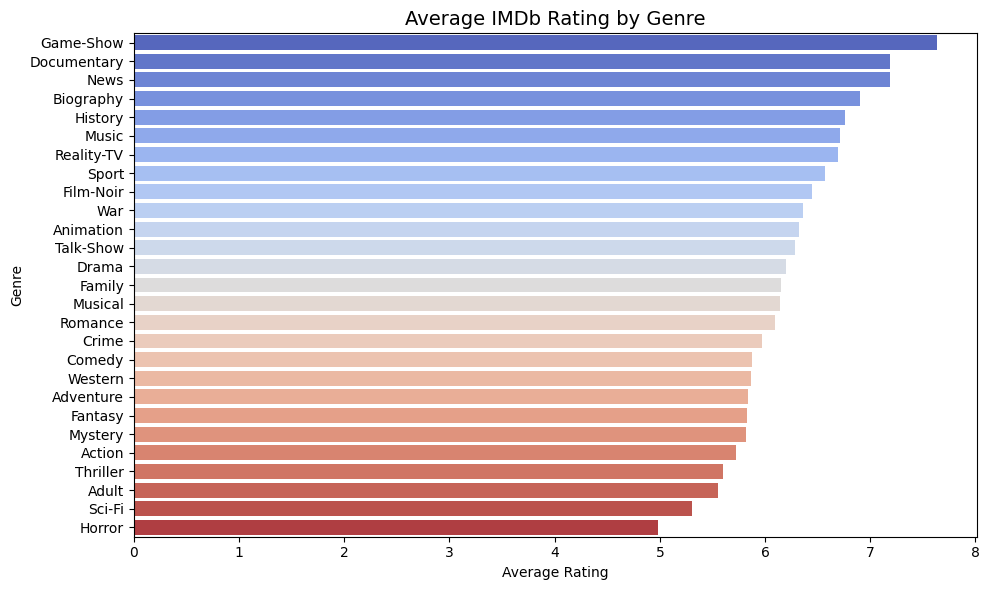

In [28]:
# Average Rating per Genre

query = """
SELECT 
    g.genreName AS genre,
    ROUND(AVG(r.averageRating), 2) AS avg_rating,
    COUNT(*) AS num_movies
FROM dim_movie AS m
JOIN title_genre_bridge AS tg ON m.tconst = tg.tconst
JOIN genre_dt AS g ON tg.genreID = g.genreID
JOIN title_ratings AS r ON m.tconst = r.tconst
GROUP BY g.genreName
ORDER BY avg_rating DESC;
"""

with engine.connect() as conn:
    genre_ratings = pd.read_sql(query, conn)

plt.figure(figsize=(10,6))
sns.barplot(x="avg_rating", y="genre", hue="genre", data=genre_ratings, palette="coolwarm")
plt.title("Average IMDb Rating by Genre", fontsize=14)
plt.xlabel("Average Rating")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

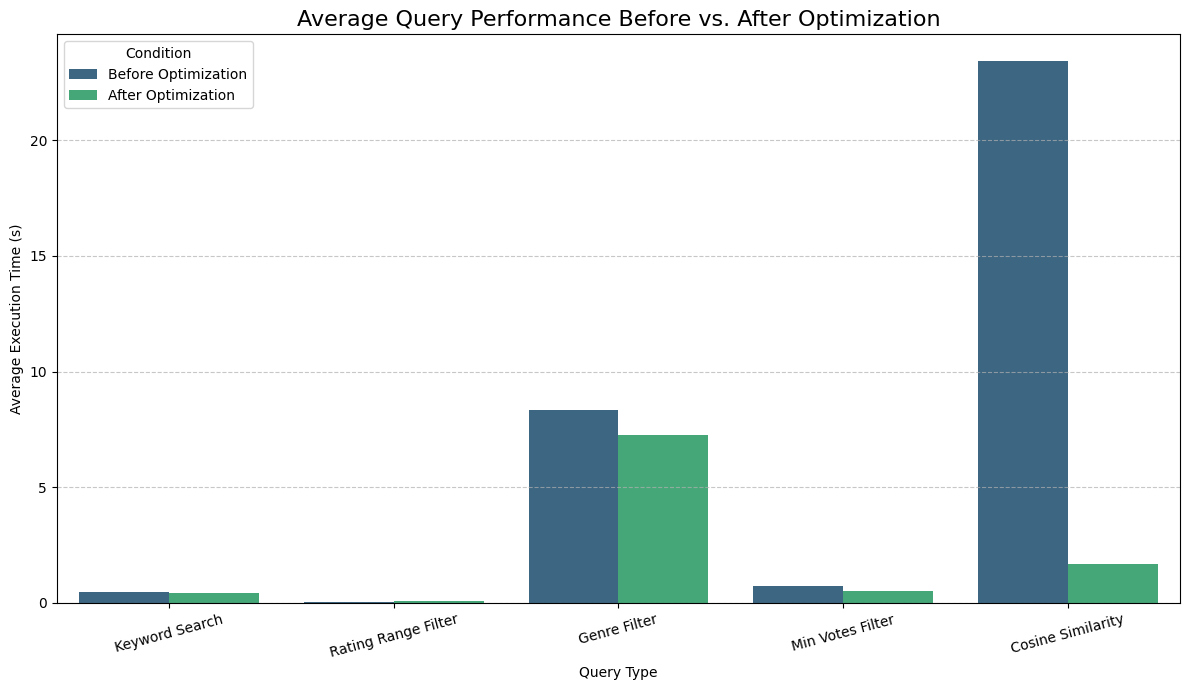

In [69]:
# Updated Average Execution Time

performance_data = {
    "Query": [
        "Keyword Search", "Keyword Search",
        "Rating Range Filter", "Rating Range Filter",
        "Genre Filter", "Genre Filter",
        "Min Votes Filter", "Min Votes Filter",
        "Cosine Similarity", "Cosine Similarity"
    ],
    "Condition": [
        "Before Optimization", "After Optimization",
        "Before Optimization", "After Optimization",
        "Before Optimization", "After Optimization",
        "Before Optimization", "After Optimization",
        "Before Optimization", "After Optimization"
    ],
    "Time (s)": [
        0.491, 0.415,  # Keyword
        0.036, 0.078,  # Rating
        8.361, 7.260,  # Genre
        0.723, 0.514,  # Min Votes
        23.413, 1.703  # Cosine Similarity
    ]
}
perf_df = pd.DataFrame(performance_data)
plt.figure(figsize=(12, 7))
sns.barplot(x="Query", y="Time (s)", hue="Condition", data=perf_df, palette="viridis")
plt.title("Average Query Performance Before vs. After Optimization", fontsize=16)
plt.ylabel("Average Execution Time (s)")
plt.xlabel("Query Type")
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Condition")
plt.tight_layout()
plt.show()

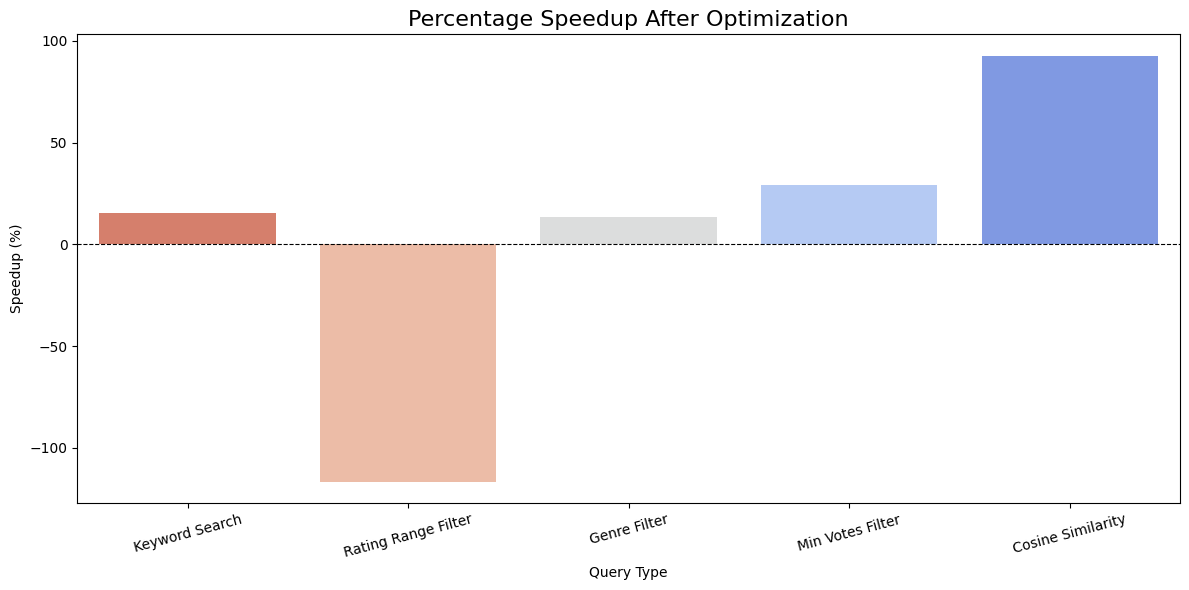

In [70]:
# Percentage Speedup

speedup_data = {
    "Query": ["Keyword Search", "Rating Range Filter", "Genre Filter", "Min Votes Filter", "Cosine Similarity"],
    "Percent Speedup": [
        (1 - 0.415 / 0.491) * 100,  # Keyword: 15.5%
        (1 - 0.078 / 0.036) * 100,  # Rating: -116.7%
        (1 - 7.260 / 8.361) * 100,  # Genre: 13.2%
        (1 - 0.514 / 0.723) * 100,  # Min Votes: 28.9%
        (1 - 1.703 / 23.413) * 100 # Cosine: 92.7%
    ]
}
speedup_df = pd.DataFrame(speedup_data)

plt.figure(figsize=(12, 6))
sns.barplot(x="Query", y="Percent Speedup", data=speedup_df, palette="coolwarm_r", hue="Query", dodge=False)
plt.title("Percentage Speedup After Optimization", fontsize=16)
plt.ylabel("Speedup (%)")
plt.xlabel("Query Type")
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend([],[], frameon=False) 
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()